In [9]:
import time
import re
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout,       # General
    Embedding, LSTM, Dense,                              # RNN
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid

print(tf.__version__)

2.3.0


## **Preprocessing**

In [10]:
# Read the Divina Commedia
url = "https://raw.githubusercontent.com/DanieleVeri/deep_comedy/ea3c999bee1ea27700c61c36e00f9dc8a768e5ee/divina_commedia.txt"
response = requests.get(url)

divina_commedia = response.text

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")
divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")
divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }

def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list

encoded_text = numerical_encoding(divina_commedia, char2idx)

def get_text_matrix(sequence, len_input):
    X = np.empty((len(sequence)-len_input, len_input))
    for i in range(X.shape[0]):
        X[i,:] = sequence[i : i+len_input]
    return X

text_matrix = get_text_matrix(encoded_text, 100)

print(text_matrix.shape)

(533803, 100)


## **LSTM training**

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1000, None, 256)         15872     
_________________________________________________________________
lstm_7 (LSTM)                (1000, None, 1024)        5246976   
_________________________________________________________________
dense_14 (Dense)             (1000, None, 256)         262400    
_________________________________________________________________
dense_15 (Dense)             (1000, None, 62)          15934     
Total params: 5,541,182
Trainable params: 5,541,182
Non-trainable params: 0
_________________________________________________________________
0
1.  	  Loss: 2.392106294631958  	  Time: 55.45ss
1
2.  	  Loss: 2.0514543056488037  	  Time: 53.66ss
2
3.  	  Loss: 1.8689590692520142  	  Time: 53.72ss
3
4.  	  Loss: 1.7254834175109863  	  Time: 53.78ss
4
5.  	  Loss: 1.6298097372055054  

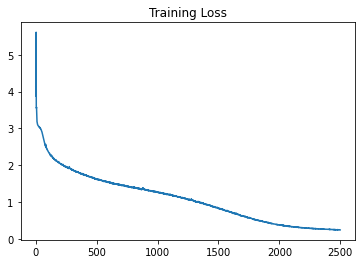

In [13]:
# size of vocabulary
vocab_size = len(char2idx)

# size of mini batches during training
batch_size = 1000
# size of training subset at each epoch
subset_size = batch_size * 100
embedding_size = 256
lstm_size = 1024
hidden_size = 256

n_epochs = 25
learning_rate = 1e-3

char_input = Input(shape=(batch_size,))
RNN = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(batch_size, None)),
    
    LSTM(lstm_size, return_sequences = True),
    
    Dense(hidden_size, activation = relu), 
    
    Dense(vocab_size)
])
RNN.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

# This is an Autograph function
# its decorator makes it a TF op - i.e. much faster
@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        current_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                y, RNN(x), from_logits = True))
    gradients = tape.gradient(current_loss, RNN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RNN.trainable_variables))
    return current_loss

loss_history = []

for epoch in range(n_epochs):
    start = time.time()
    print(epoch)
    
    # Take subsets of train and target
    sample = np.random.randint(0, text_matrix.shape[0]-1, subset_size)
    sample_train = text_matrix[ sample , : ]
    sample_target = text_matrix[ sample+1 , : ]
    
    for iteration in range(sample_train.shape[0] // batch_size):
        take = iteration * batch_size
        x = sample_train[ take:take+batch_size , : ]
        y = sample_target[ take:take+batch_size , : ]

        current_loss = train_on_batch(x, y)
        loss_history.append(current_loss)
    
    print("{}.  \t  Loss: {}  \t  Time: {}ss".format(
        epoch+1, current_loss.numpy(), round(time.time()-start, 2)))
    
    
plt.plot(loss_history)
plt.title("Training Loss")
plt.show()

RNN.save("/text_generator_RNN_00.h5")

## **LSTM generation:**

In [14]:
generator = Sequential([
    Embedding(vocab_size, embedding_size,
              batch_input_shape=(1, None)),
    LSTM(lstm_size, return_sequences = True, stateful=True),
    Dense(hidden_size, activation = relu), 
    Dense(vocab_size)
])

generator.summary()

# Import trained weights from RNN to generator
generator.set_weights(RNN.get_weights())

def generate_text(start_string, num_generate = 1000, temperature = 1.0):
    
    # Vectorize input string
    input_eval = [char2idx[s] for s in start_string]  
    input_eval = tf.expand_dims(input_eval, 0)
    
    text_generated = [] # List to append predicted chars 
    
    idx2char = { v: k for k, v in char2idx.items() }  # invert char-index mapping
    
    generator.reset_states()
    
    for i in range(num_generate):
        predictions = generator(input_eval)
        predictions = tf.squeeze(predictions, 0)
        
        # sample next char based on distribution and temperature
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
        
    return (start_string + ''.join(text_generated))

init="""
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
"""
print(generate_text(init))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (1, None, 256)            15872     
_________________________________________________________________
lstm_8 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_16 (Dense)             (1, None, 256)            262400    
_________________________________________________________________
dense_17 (Dense)             (1, None, 62)             15934     
Total params: 5,541,182
Trainable params: 5,541,182
Non-trainable params: 0
_________________________________________________________________

Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura,
chè la diritta via era smarrita.
  Ahi quanto a dir de la destra scempie
trovai pur sei le lettere che 'ncise
quest'è quanti molti poco s'imbiancea:
  "Or dipinto giù per 